In [1]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import subprocess
import scipy as sc
from itertools import product

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.figsize": (6, 5),
    "text.latex.preamble": "\n".join([
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[T1]{fontenc}",
        r"\usepackage[detect-all,locale=FR]{siunitx}",
    ]),
    'lines.markersize': 10,
    'lines.color': 'grey',
    'scatter.marker': '+',
    'errorbar.capsize': 3,
    'savefig.bbox': 'tight',
})

In [2]:
path = '../'
executable = 'bin/ex2'
export_path = path + 'rapport/figures/'
data_path = 'data/'
config_path = 'bin/'
config_name = 'poincarre1'
config_ext = '.conf'

In [3]:
def stringify_dict(d: dict, sep=',') -> str:
    return sep.join(map(lambda a: str(a[0]) + "=" + str(a[1]), tuple(d.items())))

In [4]:
def run(config_file: str, output_file: str, params: dict = {}) -> None:
    options = stringify_dict(params, sep=' ')
    cmd = f"{path}{executable} {path}{config_file} output='{path}{output_file}' {options}"
    print(f"Running command `{cmd}`\n", end='')
    subprocess.run(cmd, shell=True, stdout=subprocess.DEVNULL)
    return params

In [5]:
def load_conf() -> dict:
    conf = {}
    with open(path + config_path + config_name + config_ext, 'r') as f:
        lines = f.read().split('\n')

    for line in lines:
        if not line:
            continue
        name, _, val, *_ = line.split(' ')
        name = name.strip()
        val = val.strip()
        try:
            conf[name] = float(val)
        except ValueError:
            conf[name] = val
    
    return conf

In [6]:
conf = load_conf()

omega0 = np.sqrt(conf['g']/conf['L'])
2*omega0

14.007141035914502

In [7]:
%%bash
cd .. && make clean && make

clang++ -o bin/ex2 src/Ex2_2024_student.cpp -std=c++17 -Wall -Wextra -O2 


In [8]:
from concurrent.futures import ProcessPoolExecutor, Future
all_params = (
    {'theta0': np.pi/6, 'thetadot0': 2},
    *({'theta0': 0, 'thetadot0': i} for i in [
        # Peanut
        0.01, 2, 4,
        # Border
        7, 10, 11.875,
        12.13,
        # Chaos
        14, 16,
        # A plus chaos
        20
    ]),
    # {'theta0': 7*np.pi/11, 'thetadot0': 0},
    # {'theta0': 14*np.pi/23, 'thetadot0': 0},
    # *({'theta0': i, 'thetadot0': 0} for i in [
    #     # Peanut
    #     0.0001, np.pi/6, np.pi/4, np.pi/2,
    #     # Border
    #     7*np.pi/11, 8*np.pi/13, 14*np.pi/23,
    #     # Chaos
    #     5*np.pi/6, np.pi-1e-6
    # ]),
)

def done(fut: Future):
    print(f"Done processing {fut.result()}")

# Run simulations *IN PARALLEL*
outputs = []  # List to store output file names
with ProcessPoolExecutor(max_workers=8) as p:
    for params in all_params:
        options = stringify_dict(params)
        output_file = f"{data_path}{config_name},{options}.out"
        outputs.append(output_file)
        future = p.submit(run, f'{config_path}{config_name}{config_ext}', output_file, params)
        future.add_done_callback(done)

# outputs = []  # List to store output file names
# for params in all_params:
#     output_file = f"{data_path}{config_name},{stringify_dict(params)}.out"
#     outputs.append(output_file)
#     run(f'{config_path}{config_name}{config_ext}', output_file, params)

Running command `../bin/ex2 ../bin/poincarre1.conf output='../data/poincarre1,theta0=0,thetadot0=4.out' theta0=0 thetadot0=4`
Running command `../bin/ex2 ../bin/poincarre1.conf output='../data/poincarre1,theta0=0,thetadot0=0.01.out' theta0=0 thetadot0=0.01`
Running command `../bin/ex2 ../bin/poincarre1.conf output='../data/poincarre1,theta0=0,thetadot0=2.out' theta0=0 thetadot0=2`
Running command `../bin/ex2 ../bin/poincarre1.conf output='../data/poincarre1,theta0=0.5235987755982988,thetadot0=2.out' theta0=0.5235987755982988 thetadot0=2`
Running command `../bin/ex2 ../bin/poincarre1.conf output='../data/poincarre1,theta0=0,thetadot0=10.out' theta0=0 thetadot0=10`
Running command `../bin/ex2 ../bin/poincarre1.conf output='../data/poincarre1,theta0=0,thetadot0=12.13.out' theta0=0 thetadot0=12.13`
Running command `../bin/ex2 ../bin/poincarre1.conf output='../data/poincarre1,theta0=0,thetadot0=7.out' theta0=0 thetadot0=7`
Running command `../bin/ex2 ../bin/poincarre1.conf output='../data/p

In [9]:
# Load stuff in memory
all_data = {}

for file, params in zip(outputs, all_params):
    data = np.loadtxt(path + file)
    all_data[file] = (params, np.copy(data))

# Plots!

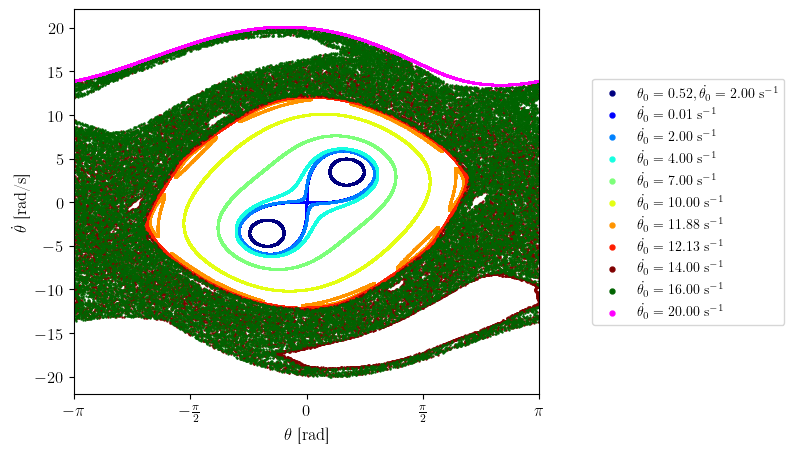

In [10]:
%matplotlib inline
# plt.close()
colors = mpl.colormaps['jet'](np.linspace(0, 1, len(all_data)-2))
for i, (params, data) in enumerate(all_data.values()):
    theta, thetadot = data[:,1], data[:,2]
    modded = np.mod(theta+np.pi,2*np.pi)-np.pi
    # if params['thetadot0']>0:
    if params['theta0'] != 0:
        label = f"$\\theta_0={params['theta0']:.2f}, \\dot{{\\theta_0}}={params['thetadot0']:.2f}$ s$^{{-1}}$"
    else:
        label = f"$\\dot{{\\theta_0}}={params['thetadot0']:.2f}$ s$^{{-1}}$"
    if i==(len(all_data)-2):
        color = 'darkgreen'
    elif i==(len(all_data)-1):
        color = 'magenta'
    else:
        color=colors[i]
    plt.scatter(
        modded, thetadot, s=2, marker='.', color=color,
        label=label
    )
    # else:
    #     plt.scatter(modded, thetadot, s=1, marker='.', label=f"$\\theta_0={params['theta0']:.2f}$")
plt.xlabel(r'$\theta$ [rad]')
plt.ylabel(r'$\dot{\theta}$ [rad/s]')
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), markerscale=5)
# plt.grid()
plt.xlim(-np.pi, np.pi)
ticks = np.arange(-np.pi, np.pi+0.1, np.pi/2)
# labels = [
#     r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{\pi}{2}$', r'$-\frac{\pi}{4}$',
#     r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$',
# ]
labels = [
    r'$-\pi$', r'$-\frac{\pi}{2}$',
    r'$0$', r'$\frac{\pi}{2}$', r'$\pi$',
]
plt.xticks(ticks, labels)
# plt.axis('equal')
plt.savefig(export_path + 'poincare_overkill.png', dpi=200)
plt.show()